<a href="https://colab.research.google.com/github/ancestor9/2025_Fall_text-image-deep-learning-with-python/blob/main/chapter13_timeseries_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [ ]:
!pip install keras keras-hub --upgrade -q

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.4/1.4 MB 2.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 947.9/947.9 kB 24.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.21.1 requires keras-hub==0.21.1, but you have keras-hub 0.22.1 which is incompatible.


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Timeseries forecasting

### A temperature forecasting example with RNN

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-08-22 01:04:56--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.36.96, 52.217.96.70, 52.216.51.80, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.36.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‚Äòjena_climate_2009_2016.csv.zip‚Äô

jena_climate_2009_2 100%[===================>]  12.94M  15.0MB/s    in 0.9s    

2025-08-22 01:04:57 (15.0 MB/s) - ‚Äòjena_climate_2009_2016.csv.zip‚Äô saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Inspecting the data of the Jena weather dataset

In [ ]:
import os

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
import pandas as pd
df = pd.read_csv('/content/jena_climate_2009_2016.csv')
df

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90   
1       01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28   
2       01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31   
3       01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07   
4       01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04   
...                     ...       ...       ...       ...          ...   
420446  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420447  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420448  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420449  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420450  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0        93.30          3.33          3.11          0.22       1.94   
1        93.40          3.23          3.02          0.21       1.89   
2        93.90          3.21          3.01          0.20       1.88   
3        94.20          3.26          3.07          0.19       1.92   
4        94.10          3.27          3.08          0.19       1.92   
...        ...           ...           ...           ...        ...   
420446   73.10          4.52          3.30          1.22       2.06   
420447   69.71          4.77          3.32          1.44       2.07   
420448   67.91          4.84          3.28          1.55       2.05   
420449   71.80          4.46          3.20          1.26       1.99   
420450   75.70          4.27          3.23          1.04       2.01   

        H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0                  3.12       1307.75      1.03           1.75     152.3  
1                  3.03       1309.80      0.72           1.50     136.1  
2                  3.02       1310.24      0.19           0.63     171.6  
3                  3.08       1309.19      0.34           0.50     198.0  
4                  3.09       1309.00      0.32           0.63     214.3  
...                 ...           ...       ...            ...       ...  
420446             3.30       1292.98      0.67           1.52     240.0  
420447             3.32       1289.44      1.14           1.92     234.3  
420448             3.28       1288.39      1.08           2.00     215.2  
420449             3.20       1293.56      1.49           2.16     225.8  
420450             3.23       1296.38      1.23           1.96     184.9  

[420451 rows x 15 columns]

Parsing the data

In [ ]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [ ]:
temperature

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [ ]:
len(temperature)

420451

In [ ]:
raw_data.shape

(420451, 14)

Plotting the temperature timeseries

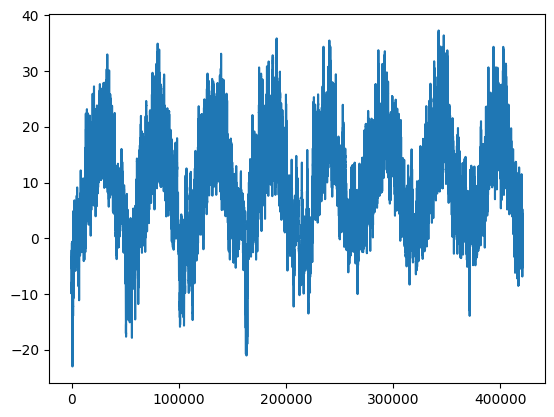

In [ ]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

Plotting the first 10 days of the temperature timeseries

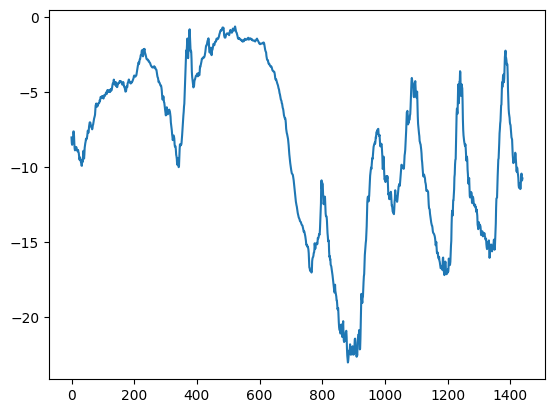

In [ ]:
'''
Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞©Ïãù: Ïò®ÎèÑ Îç∞Ïù¥ÌÑ∞Îäî 10Î∂ÑÎßàÎã§ 1ÌöåÏî© Í∏∞Î°ùÎê©ÎãàÎã§.

ÌïòÎ£® ÎèôÏïà Í∏∞Î°ù ÌöüÏàò: ÌïòÎ£®Îäî 24ÏãúÍ∞ÑÏù¥Í≥†, Ìïú ÏãúÍ∞ÑÏùÄ 60Î∂Ñ ‚Üí 1ÏãúÍ∞ÑÏóê Í∏∞Î°ùÎêòÎäî ÌöüÏàò = 60 √∑ 10 = 6Î≤à
ÌïòÎ£® Ï†ÑÏ≤¥ Í∏∞Î°ù ÌöüÏàò = 24ÏãúÍ∞Ñ √ó 6Î≤à = 144 Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏

10Ïùº ÎèôÏïà Í∏∞Î°ù ÌöüÏàò: ÌïòÎ£®Ïóê 144Í∞úÍ∞Ä ÏûàÏúºÎØÄÎ°ú, 10Ïùº ÎèôÏïàÏùÄ 144 √ó 10 = 1,440 Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏
'''

plt.plot(range(1440), temperature[:1440])

### The most common timeseries-related task is ***forecasting*** : predicting what will happen next in a series.

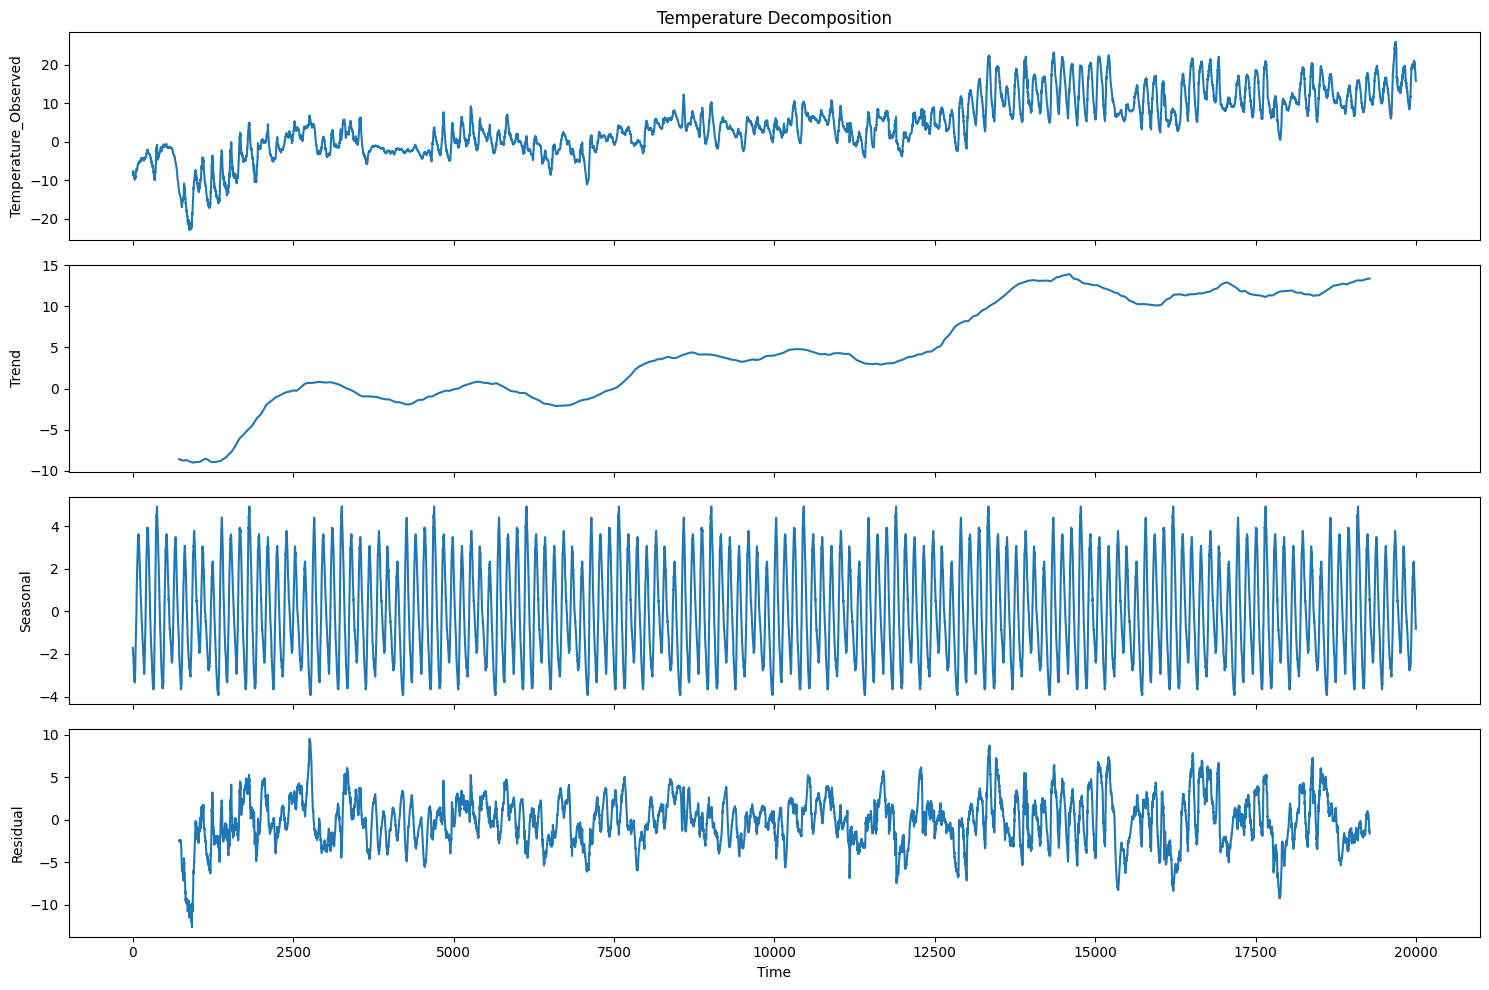

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'temperature' is a pandas Series or can be converted to one
# If 'temperature' is a numpy array, convert it to a pandas Series with a dummy index or a time index if available
# For simplicity, I'll create a dummy index here. Replace with actual time index if available.
temperature_series = pd.Series(temperature[:20000])

# Perform decomposition (additive model is often suitable for temperature data)
decomposition = seasonal_decompose(temperature_series, model='additive', period=1440) # Assuming a daily pattern of 1440 data points

# Plot the decomposed components as separate plots
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Temperature_Observed')
axes[0].set_title('Temperature Decomposition')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Time')

plt.tight_layout()
plt.show()

### Unlike the types of data you‚Äôve encountered so far, working with timeseries involves understanding the dynamics of a system‚Äîits periodic cycles, how it trends over time, its regular regime and its sudden spikes."

### ÏúÑ Í∑∏Î¶ºÏùò ÏÇ¨Ïù¥ÌÅ¥, Ï£ºÍ∏∞Î•º Ìï¥ÏÑùÌïòÍ≥† Í≥ÑÏ†àÏùÄ Ïñ∏Ï†úÏù∏Í∞Ä?

### ÏãúÍ∞ÑÏùÑ Í≥†Î†§ÌïòÏó¨ ÌõàÎ†®Í≥º Í≤ÄÏ¶ù, Îç∞Ïù¥ÌÑ∞Î•º split ÌïúÎã§
Computing the number of samples we'll use for each data split

In [ ]:
print("num_total_raw_data", len(raw_data))

# ÏãúÍ∞Ñ ÏàúÏÑúÎåÄÎ°ú ÌõàÎ†®/Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Íµ¨Î∂ÑÌïòÍ∏∞
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_total_raw_data 420451
num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


#### Preparing the data
Normalizing the data

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Understanding timeseries_dataset_from_array()

In [ ]:
import numpy as np
import keras

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating datasets for training, validation, and testing

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples,
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
)

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


#### A common-sense, non-machine-learning baseline

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


#### Let's try a basic machine learning model

In [ ]:
import keras
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Flatten()(inputs) # Flatten layer causes issues with JAX backend
x = layers.GlobalAveragePooling1D()(inputs) # Use GlobalAveragePooling1D instead
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 49s 58ms/step - loss: 90.7069 - mae: 7.5282 - val_loss: 27.5501 - val_mae: 4.1419
Epoch 2/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44s 52ms/step - loss: 26.2605 - mae: 4.0670 - val_loss: 20.7176 - val_mae: 3.6058
Epoch 3/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44s 54ms/step - loss: 22.0788 - mae: 3.7517 - val_loss: 20.3586 - val_mae: 3.5681
Epoch 4/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44s 53ms/step - loss: 21.7376 - mae: 3.7225 - val_loss: 20.2643 - val_mae: 3.5599
Epoch 5/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 61s 75ms/step - loss: 21.5201 - mae: 3.7030 - val_loss: 20.3010 - val_mae: 3.5640
Epoch 6/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 50s 60ms/step - loss: 21.3445 - mae: 3.6875 - val_loss: 20.2019 - val_mae: 3.5536
Epoch 7/10
819/819 ‚îÅ‚îÅ‚îÅ

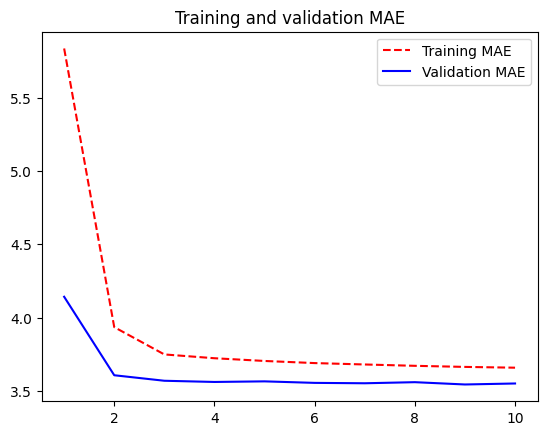

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

#### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 74s 89ms/step - loss: 39.0179 - mae: 4.6947 - val_loss: 16.0927 - val_mae: 3.1648
Epoch 2/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 99s 119ms/step - loss: 14.7210 - mae: 3.0421 - val_loss: 14.9079 - val_mae: 3.0466
Epoch 3/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 67s 82ms/step - loss: 12.7916 - mae: 2.8295 - val_loss: 14.2530 - val_mae: 2.9683
Epoch 4/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 67s 81ms/step - loss: 11.7184 - mae: 2.7073 - val_loss: 13.9236 - val_mae: 2.9348
Epoch 5/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 67s 81ms/step - loss: 11.1272 - mae: 2.6368 - val_loss: 13.9730 - val_mae: 2.9341
Epoch 6/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 66s 81ms/step - loss: 10.6140 - mae: 2.5730 - val_loss: 14.5104 - val_mae: 2.9944
Epoch 7/10
819/819 ‚îÅ‚îÅ‚î

### Recurrent neural networks

In [ ]:
import keras
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_lstm.keras")
print("Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 108s 129ms/step - loss: 81.4540 - mae: 7.0099 - val_loss: 19.5796 - val_mae: 3.2817
Epoch 2/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 103s 122ms/step - loss: 17.7731 - mae: 3.1577 - val_loss: 11.5683 - val_mae: 2.5813
Epoch 3/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 98ms/step - loss: 11.9733 - mae: 2.6532 - val_loss: 10.0781 - val_mae: 2.4458
Epoch 4/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 80s 97ms/step - loss: 10.5011 - mae: 2.5060 - val_loss: 9.7757 - val_mae: 2.4171
Epoch 5/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 103s 125ms/step - loss: 9.7535 - mae: 2.4228 - val_loss: 9.5582 - val_mae: 2.3897
Epoch 6/10
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 99ms/step - loss: 9.1770 - mae: 2.3588 - val_loss: 9.5970 - val_mae: 2.4057
Epoch 7/10
819/819 ‚îÅ‚îÅ‚î

#### Understanding recurrent neural networks

In [ ]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

#### A recurrent layer in Keras

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

#### Getting the most out of recurrent neural networks

#### Using recurrent dropout to fight overfitting

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_lstm_dropout.keras", save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
)

Epoch 1/50
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 197s 236ms/step - loss: 55.1504 - mae: 5.5597 - val_loss: 11.1972 - val_mae: 2.5564
Epoch 2/50
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 187s 224ms/step - loss: 16.8801 - mae: 3.1748 - val_loss: 9.4764 - val_mae: 2.3866
Epoch 3/50
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 195s 238ms/step - loss: 15.3822 - mae: 3.0472 - val_loss: 9.1928 - val_mae: 2.3494
Epoch 4/50
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 233s 284ms/step - loss: 14.5812 - mae: 2.9697 - val_loss: 9.0776 - val_mae: 2.3386
Epoch 5/50
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 186s 226ms/step - loss: 14.1465 - mae: 2.9208 - val_loss: 8.9809 - val_mae: 2.3288
Epoch 6/50
819/819 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 234s 285ms/step - loss: 13.7426 - mae: 2.8780 - val_loss: 8.8545 - val_mae: 2.3113
Epoch 7/50
819/819 ‚î

#### Stacking recurrent layers

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_stacked_gru_dropout.keras", save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

#### Using bidirectional RNNs

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

### Going even further

### Different kinds of timeseries tasks

### **1. Classification (Î∂ÑÎ•ò)**

üëâ Ïòà: ÏÇ¨Ïö©ÏûêÍ∞Ä ÌïòÎ£® ÎèôÏïà ÌÅ¥Î¶≠Ìïú ÌöüÏàò ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞Î•º Î≥¥Í≥† ÏÇ¨ÎûåÏù∏ÏßÄ/Î¥áÏù∏ÏßÄ Î∂ÑÎ•ò

### **2. Event Detection (Ïù¥Î≤§Ìä∏ ÌÉêÏßÄ)**

üëâ Ïòà: ÏùåÏÑ± Ïä§Ìä∏Î¶º Í∞ôÏùÄ ÏãúÍ≥ÑÏó¥ÏóêÏÑú ÌäπÏ†ï Ìå®ÌÑ¥("hotword") Î∞úÏÉù Ïó¨Î∂Ä ÌÉêÏßÄ

### **3. Anomaly Detection (Ïù¥ÏÉÅÏπò ÌÉêÏßÄ)**

üëâ Ïòà: Ï†ïÏÉÅÏ†ÅÏù∏ Î≥ÄÎèô Î≤îÏúÑÎ•º Î≤óÏñ¥ÎÇú Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏Î•º Ïù¥ÏÉÅÏπòÎ°ú ÌåêÎ≥Ñ(Ïòà: ÏÑºÏÑú Í≥†Ïû• ÌÉêÏßÄ, Í∏àÏúµ Í±∞Îûò Ïù¥ÏÉÅ ÌÉêÏßÄ Îì± ÏÇ¨Î°Ä)

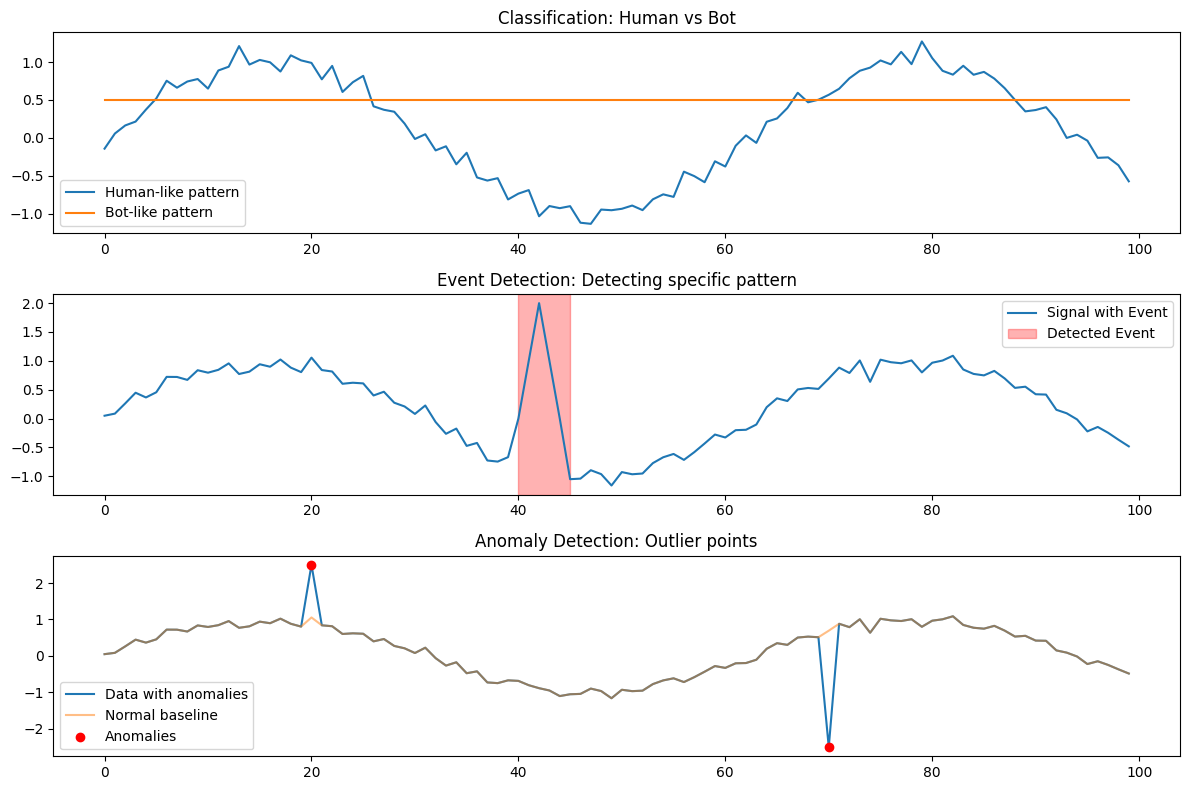

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
time = np.arange(100)

# Í≥µÌÜµ Ï†ïÏÉÅ ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞
data = np.sin(time * 0.1) + np.random.normal(scale=0.1, size=len(time))

# 1. Classification: ÏÇ¨Îûå vs Î¥á (Í∞ÑÎã®Ìûà Ìå®ÌÑ¥ ÎπÑÍµêÏö©)
human = np.sin(time * 0.1) + np.random.normal(scale=0.1, size=len(time))
bot = np.ones(len(time)) * 0.5  # ÏùºÏ†ïÌïú Í∞í

# 2. Event Detection: ÌäπÏ†ï Ìå®ÌÑ¥ Ïã¨Ïñ¥ÎëêÍ∏∞
event_pattern = np.array([0,1,2,1,0])
signal = data.copy()
signal[40:45] = event_pattern

# 3. Anomaly Detection: Ïù¥ÏÉÅÏπò Ï∂îÍ∞Ä
anomaly_data = data.copy()
anomaly_points = {20: 2.5, 70: -2.5}
for k,v in anomaly_points.items():
    anomaly_data[k] = v

# Í∑∏Î¶º Í∑∏Î¶¨Í∏∞
fig, axes = plt.subplots(3,1,figsize=(12,8))

# Classification
axes[0].plot(time, human, label="Human-like pattern")
axes[0].plot(time, bot, label="Bot-like pattern")
axes[0].set_title("Classification: Human vs Bot")
axes[0].legend()

# Event Detection
axes[1].plot(time, signal, label="Signal with Event")
axes[1].axvspan(40,45, color="red", alpha=0.3, label="Detected Event")
axes[1].set_title("Event Detection: Detecting specific pattern")
axes[1].legend()

# Anomaly Detection
axes[2].plot(time, anomaly_data, label="Data with anomalies")
axes[2].plot(time, data, alpha=0.5, label="Normal baseline")
axes[2].scatter(list(anomaly_points.keys()), list(anomaly_points.values()), color="red", label="Anomalies", zorder=5)
axes[2].set_title("Anomaly Detection: Outlier points")
axes[2].legend()

plt.tight_layout()
plt.show()


### ‚úÖ ÏãúÍ≥ÑÏó¥ ÌôúÏö© Î∂ÑÏïº Summary

#### 1. Î∂ÑÎ•ò (Classification) ‚Üí ÏãúÍ≥ÑÏó¥ Ï†ÑÏ≤¥Ïùò Ìå®ÌÑ¥ÏùÑ Î≥¥Í≥† Í∑∏Í≤ÉÏù¥ Ïñ¥Îñ§ ÌÅ¥ÎûòÏä§Ïóê ÏÜçÌïòÎäîÏßÄ ÌåêÎ≥Ñ

> ÏòàÏãú: ÏõπÏÇ¨Ïù¥Ìä∏ Î∞©Î¨∏ÏûêÏùò ÌôúÎèô Î°úÍ∑∏Î•º Î≥¥Í≥† ÏÇ¨ÎûåÏù∏ÏßÄ Î¥áÏù∏ÏßÄ Î∂ÑÎ•ò

> ÌäπÏßï: Ï†ÑÏ≤¥ ÏãúÍ≥ÑÏó¥ÏùÑ ÌïòÎÇòÏùò Îã®ÏúÑÎ°ú Ìï¥ÏÑù

#### 2. Ïù¥Î≤§Ìä∏ ÌÉêÏßÄ (Event Detection) ‚Üí Í∏¥ ÏãúÍ≥ÑÏó¥ ÏÜçÏóêÏÑú ÌäπÏ†ï Ïù¥Î≤§Ìä∏/Ìå®ÌÑ¥Ïù¥ Î∞úÏÉùÌïú ÏàúÍ∞ÑÏùÑ ÌÉêÏßÄ

> ÏòàÏãú: ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ‚ÄúOK Google‚Äù Í∞ôÏùÄ Ìï´ÏõåÎìú Î∞úÏÉù ÏãúÏ†ê ÌÉêÏßÄ

> ÌäπÏßï: Î∂ÄÎ∂Ñ Íµ¨Í∞ÑÏùÑ Ï∞æÏïÑÎÇ¥Îäî Î¨∏Ï†ú

#### 3. Ïù¥ÏÉÅÏπò ÌÉêÏßÄ (Anomaly Detection) ‚Üí Ï†ïÏÉÅÏ†ÅÏù∏ Ìå®ÌÑ¥ÏóêÏÑú Î≤óÏñ¥ÎÇú ÎπÑÏ†ïÏÉÅÏ†Å Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏Î•º Ï∞æÏïÑÎÉÑ

> ÏòàÏãú: ÏÑºÏÑú Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Í∏∞Í≥Ñ Í≥†Ïû• Ïã†Ìò∏, Í∏àÏúµ Í±∞Îûò Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ïù¥ÏÉÅ Í±∞Îûò ÌÉêÏßÄ

> ÌäπÏßï: Ï†ïÏÉÅ Î∂ÑÌè¨ Î≤îÏúÑÏôÄ ÎπÑÍµêÌï¥ **Ïù¥ÌÉàÏ†ê(outlier)**ÏùÑ ÌåêÎ≥Ñ